In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
import torch
import torch.nn.functional as F
import itertools
from scipy.stats import pointbiserialr
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer
from sklearn.metrics import average_precision_score
from scipy.stats import spearmanr
from scipy.stats import entropy
from collections import defaultdict

from tqdm.auto import tqdm
import re

pd.set_option('display.max_columns', 500)

Features epigenomiche con FFNN e sequenze raw con CNN o LSTM.
Task:
- Identificazione di enhancers e promoters
- 2 directories: enhancers and promoters: quali sono attivi e inattivi nelle regioni 

tasks:
- Active PROMOTERS vs inactive PROMOTERS
- Active ENHANCERS vs inactive ENHANCERS

- Active ENHANCERS vs active PROMOTERS
- Inactive ENHANCERS vs inactive PROMOTERS
- Active ENHANCERS + active PROMOTERS vs inactive

Enhancers.bed indica l’etichettatura
Per ogni posizione 1 se la regione è attiva, 0 se è inattiva.

1 dataset per ogni regione regolatori da trattare indipendentemente. 7 diversi dataset. 
Usa cdv e pacchetto di luca

One hot encoding delle sequence raw. 


An immortalised cell line is a population of cells from a multicellular organism which would normally not proliferate indefinitely but, due to mutation, have evaded normal cellular senescence and instead can keep undergoing division. The cells can therefore be grown for prolonged periods in vitro. The mutations required for immortality can occur naturally or be intentionally induced for experimental purposes. Immortal cell lines are a very important tool for research into the biochemistry and cell biology of multicellular organisms. Immortalised cell lines have also found uses in biotechnology.

1. FLAT FEATURES
- A549: they are adenocarcinomic human alveolar basal epithelial cells, and constitute a cell line that was first developed in 1972 by D. J. Giard, et al. through the removal and culturing of cancerous lung tissue in the explanted tumor of a 58-year-old caucasian male. The cells are used as models for the study of lung cancer 
- GM12878: B-Lymphocyte with Epstein-Barr Virus. it is a lymphoblastoid cell line produced from the blood of a female donor with northern and western European ancestry by EBV transformation. A lymphoblast is a modified naive lymphocyte with altered cell morphology. It occurs when the lymphocyte is activated by an antigen (from antigen-presenting cells) and increased in volume by nucleus and cytoplasm growth as well as new mRNA and protein synthesis.Lymphoblasts can also refer to immature cells which typically differentiate to form mature lymphocytes. Normally lymphoblasts are found in the bone marrow, but in acute lymphoblastic leukemia (ALL), lymphoblasts proliferate uncontrollably and are found in large numbers in the peripheral blood.
- H1: human embryonic stem cell line, usually called H1-hESC and on occasion just H1
- HEK293: Human embryonic kidney 293 cells, also often referred to as HEK 293, HEK-293, 293 cells, or less precisely as HEK cells, are a specific cell line originally derived from human embryonic kidney cells grown in tissue culture taken from a female fetus.
- HepG2:  is a human liver cancer cell line. Hep G2 is an immortal cell line which was derived in 1975 from the liver tissue of a 15-year-old Caucasian male from Argentina with a well-differentiated hepatocellular carcinoma.
- K562: they were the first human immortalised myelogenous leukemia cell line to be established. K562 cells are of the erythroleukemia type, and the cell line is derived from a 53-year-old female chronic myelogenous leukemia patient in blast crisis
- MCF-7: is a breast cancer cell line isolated in 1970 from a 69-year-old White woman.

2. SEQUENCE DATA
- .fa file: it contains the effective genomic sequence

3. TARGET
- .bed file: it tells us wether a certain genomic region of each cell line contains or not an enhancer or a promoter

In [8]:
from BIOINF_tesi.data_pipe import Load_Create_Task

In [4]:
data = Load_Create_Task()
data.load(verbose=True)

Loading data:   0%|          | 0/9 [00:00<?, ?it/s]

Loading data:   0%|          | 0/10 [00:00<?, ?it/s]

enhancers files:
['A549', 'GM12878', 'H1', 'HEK293', 'HEPG2', 'K562', 'MCF7', 'bed', 'fa']

bed has shape: (63285, 11)
MCF7 has shape: (63285, 121)
GM12878 has shape: (63285, 156)
A549 has shape: (63285, 52)
H1 has shape: (63285, 62)
K562 has shape: (63285, 433)
fa has shape: (63285, 4)
HEPG2 has shape: (63285, 566)
HEK293 has shape: (63285, 200)

promoters files:
['A549', 'GM12878', 'H1', 'HEK293', 'HEPG2', 'K562', 'MCF7', 'bed', 'fa']

MCF7 has shape: (99881, 121)
fa has shape: (99881, 4)
GM12878 has shape: (99881, 156)
A549 has shape: (99881, 52)
H1 has shape: (99881, 62)
K562 has shape: (99881, 433)
HEPG2 has shape: (99881, 566)
bed has shape: (99881, 11)
HEK293 has shape: (99881, 200)


- DNA strand orientation (positive ["+"] or negative ["-"] or "." if no strand)

- csv files: Per ogni linea cellulare, in corrispondenza delle stesse coordinate ci sono linee epigenomiche ex: gm12878.csv. Per ogni area c’è una serie di valori (matrice) che rappresentano features epigenomiche. Dicono in cosa è implicata la regione. H3k.. sono modificazioni istoniche <br> h3k4n1: stato della cromatina. Indica se è aperta o meno, quindi se è alta, l’area è aperta e quindi è facile che sia trascritta e vice versa.

- fasta file: regioni di 256 bp centrata

Enhancers.fasta 
Head enhancers.fa

- prima linea: cromosoma e coordinate di inizio e fine dell’area del dna

seconda linea: sequenza di basi azotate 

In [15]:
%store data

Stored 'data' (Load_Create_Task)


## CHECK MISSING VALUES

In [9]:
from BIOINF_tesi.data_pipe.dataprepare import Data_Prepare

In [22]:
data_dict, labels_dict = data.get_task('active_EP_vs_inactive_rest')

data_prep = Data_Prepare(data_dict, labels_dict)
data_prep.scale_data_genfeatures()

In [23]:
data_dict = data_prep.data_dict

In [173]:
for key in data_dict.keys():
    if key !='fa':
        for col in data_dict[key].columns:
            if data_dict[key][col].isna().sum():
                print('dataset: {}, column: {}, nan: {}'.format(key,col, data_dict[key][col].isna().sum()))
    else:
        if data_dict[key].isna().sum():
                print('dataset: {}, nan: {}'.format(key, data_dict[key].isna().sum()))

dataset: MCF7, column: ATAC-seq, nan: 91
dataset: MCF7, column: DNase-seq, nan: 91
dataset: GM12878, column: NRF1, nan: 1
dataset: GM12878, column: STAT5A, nan: 1
dataset: GM12878, column: NFIC, nan: 1
dataset: GM12878, column: KAT2A, nan: 1
dataset: GM12878, column: BATF, nan: 1
dataset: GM12878, column: NFYA, nan: 1
dataset: GM12878, column: POLR2AphosphoS2, nan: 1
dataset: GM12878, column: MXI1, nan: 1
dataset: GM12878, column: STAT3, nan: 1
dataset: GM12878, column: REST, nan: 1
dataset: GM12878, column: ATAC-seq, nan: 91
dataset: GM12878, column: GABPA, nan: 1
dataset: GM12878, column: NR2C2, nan: 1
dataset: GM12878, column: whole-genome shotgun bisulfite sequencing, nan: 254
dataset: GM12878, column: RUNX3, nan: 1
dataset: GM12878, column: H4K20me1, nan: 1
dataset: GM12878, column: USF1, nan: 1
dataset: GM12878, column: CUX1, nan: 1
dataset: GM12878, column: USF2, nan: 1
dataset: GM12878, column: TBP, nan: 1
dataset: GM12878, column: MAX, nan: 1
dataset: GM12878, column: MEF2A, n

In [174]:
data_dict_fa = data_dict['fa'].apply(lambda x: [i for i in x.lower()] )

In [30]:
import random
random.choice(['a','c','g','t'])

'g'

In [175]:
for row in data_dict_fa.index:
    if 'n' in data_dict_fa[row]:
        print('row n: {}, nan: {}'.format(row, data_dict_fa[row].count('n')))

row n: 93539, nan: 1
row n: 93540, nan: 1


We can perform data imputation since there are few missing values for each column compared to the total number of observations (at most $343$ over $163.166$) and 2 missing nucleotides in the sequence files.

## PREPROCESSING FUNCTION

In [2]:
%store -r data

In [5]:
from BIOINF_tesi.data_pipe import Build_DataLoader_Pipeline
from BIOINF_tesi.data_pipe import TASKS

In [4]:
for task in TASKS:
    data_dict, labels_dict = data.get_task(task)
    pipe_data_load = Build_DataLoader_Pipeline(data_dict, labels_dict, 
                                           type_test=['kruskal_wallis_test', 'wilcoxon_test'],
                                           intersection=True,
                                           path_name=f'{task}.pickle', 
                                           verbose=False)

Data transformation Done!

Check correlation with labels Done!

Check correlation between features Done!

Data Preprocessing Done!
Data transformation Done!

Check correlation with labels Done!

Check correlation between features Done!

Data Preprocessing Done!
Data transformation Done!

Check correlation with labels Done!

Check correlation between features Done!

Data Preprocessing Done!
Data transformation Done!

Check correlation with labels Done!

Check correlation between features Done!

Data Preprocessing Done!
Data transformation Done!

Check correlation with labels Done!

Check correlation between features Done!

Data Preprocessing Done!


In [7]:
task = TASKS[3]
data_dict, labels_dict = data.get_task(task)
pipe_data_load = Build_DataLoader_Pipeline(data_dict, labels_dict, 
                                           type_test=['kruskal_wallis_test', 'wilcoxon_test'],
                                           intersection=True,
                                           path_name=f'{task}.pickle', 
                                           verbose=False)

Minority class: inactive enhancers
Minority class: inactive enhancers
Minority class: inactive enhancers
Minority class: inactive enhancers
Minority class: inactive enhancers
Minority class: inactive enhancers
Minority class: inactive enhancers
Data transformation Done!

Check correlation with labels Done!

Check correlation between features Done!

Data Preprocessing Done!
Data Preprocessing Done!


In [9]:
task = TASKS[2]
data_dict, labels_dict = data.get_task(task)
pipe_data_load = Build_DataLoader_Pipeline(data_dict, labels_dict, 
                                           type_test=['kruskal_wallis_test', 'wilcoxon_test'],
                                           intersection=True,
                                           path_name=f'{task}.pickle', 
                                           verbose=False)

Minority class: active enhancers
Minority class: active enhancers
Minority class: active enhancers
Minority class: active enhancers
Minority class: active enhancers
Minority class: active enhancers
Minority class: active enhancers
Data transformation Done!

Check correlation with labels Done!

Check correlation between features Done!

Data Preprocessing Done!


In [20]:
loader_train, loader_test = pipe_data_load.return_data(cell_line='H1', hyper_tuning=True, 
                    sequence=True, random_state=123, augmentation=True)

In [21]:
len(loader_train)

1076

In [22]:
for i,j in loader_train:
    print(i.shape, j.sum())
    break

torch.Size([100, 4, 256]) tensor(13)


In [23]:
loader_train, loader_test = pipe_data_load.return_data(cell_line='H1', hyper_tuning=True, 
                    sequence=False, random_state=123, augmentation=True)

In [24]:
len(loader_train)

1076

In [25]:
for i,j in loader_train:
    print(i.shape, j.sum())
    break

torch.Size([100, 48]) tensor(13)


In [26]:
loader_train, loader_test = pipe_data_load.return_data(cell_line='H1', hyper_tuning=True, 
                    sequence=True, random_state=123, augmentation=False)

In [27]:
len(loader_train)

1041

In [28]:
for i,j in loader_train:
    print(i.shape, j.sum())
    break

torch.Size([100, 4, 256]) tensor(10)


In [29]:
loader_train, loader_test = pipe_data_load.return_data(cell_line='H1', hyper_tuning=True, 
                    sequence=False, random_state=123, augmentation=False)

In [30]:
len(loader_train)

1041

In [31]:
for i,j in loader_train:
    print(i.shape, j.sum())
    break

torch.Size([100, 48]) tensor(10)


---

In [16]:
for task in TASKS:
    print(f'\n{task}')
    pipe_data_load = Build_DataLoader_Pipeline(path_name=f'{task}.pickle')
    for cell in CELL_LINES:
        print(f'{cell}: {len(pipe_data_load.data_class.data_dict[cell])}')


active_E_vs_inactive_E
Data Preprocessing Done!
A549: 63285
GM12878: 63285
H1: 63285
HEK293: 63285
HEPG2: 63285
K562: 63285
MCF7: 63285

active_P_vs_inactive_P
Data Preprocessing Done!
A549: 99881
GM12878: 99881
H1: 99881
HEK293: 99881
HEPG2: 99881
K562: 99881
MCF7: 99881

active_E_vs_active_P
Data Preprocessing Done!
A549: 13905
GM12878: 25625
H1: 16367
HEK293: 19782
HEPG2: 21269
K562: 18048
MCF7: 17620

inactive_E_vs_inactive_P
Data Preprocessing Done!
A549: 149261
GM12878: 137541
H1: 146799
HEK293: 143384
HEPG2: 141897
K562: 145118
MCF7: 145546

active_EP_vs_inactive_rest
Data Preprocessing Done!
A549: 163166
GM12878: 163166
H1: 163166
HEK293: 163166
HEPG2: 163166
K562: 163166
MCF7: 163166


## LABEL IMBALANCE

In [1]:
from BIOINF_tesi.visual import plot_label_ratio

Data Preprocessing Done!


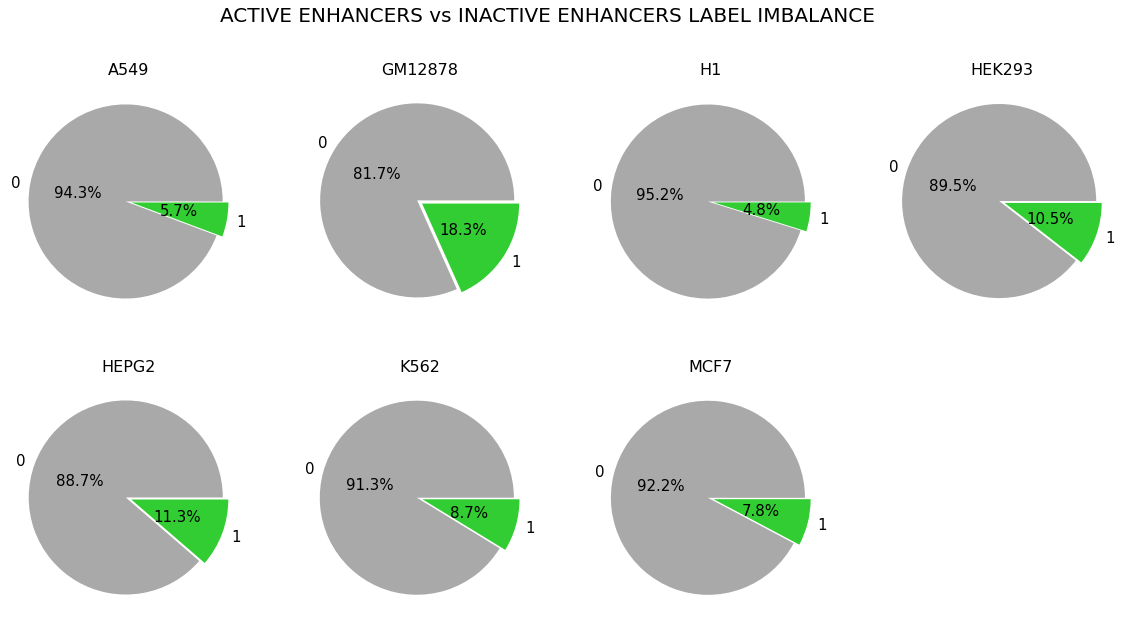

In [3]:
plot_label_ratio(TASKS[0], 'ACTIVE ENHANCERS vs INACTIVE ENHANCERS LABEL IMBALANCE')

Data Preprocessing Done!


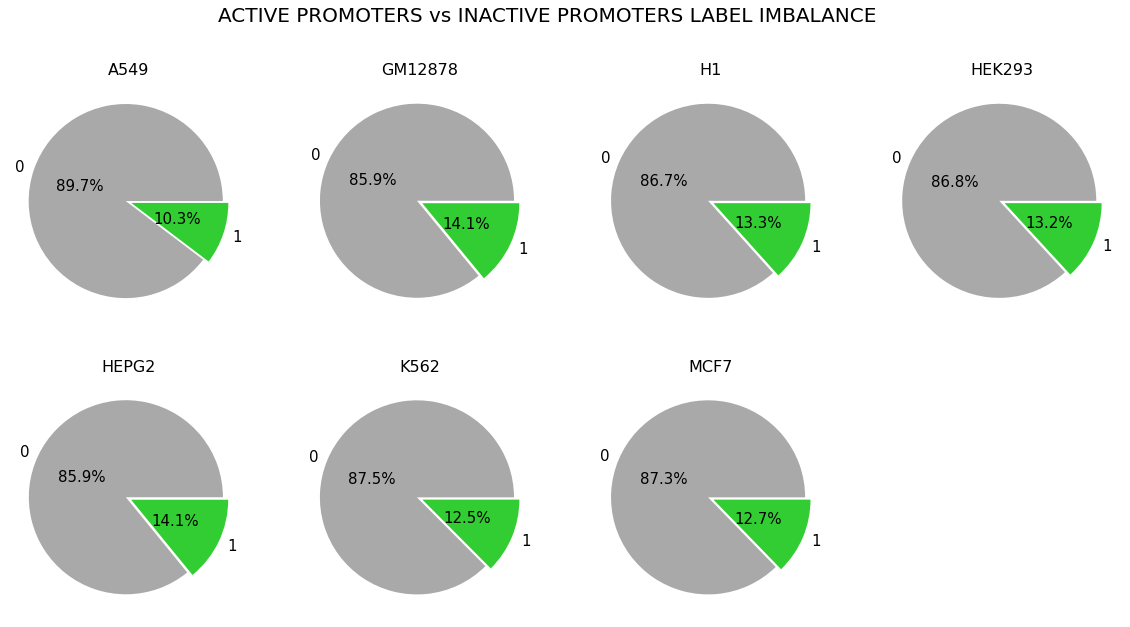

In [4]:
plot_label_ratio(TASKS[1],'ACTIVE PROMOTERS vs INACTIVE PROMOTERS LABEL IMBALANCE')

Data Preprocessing Done!


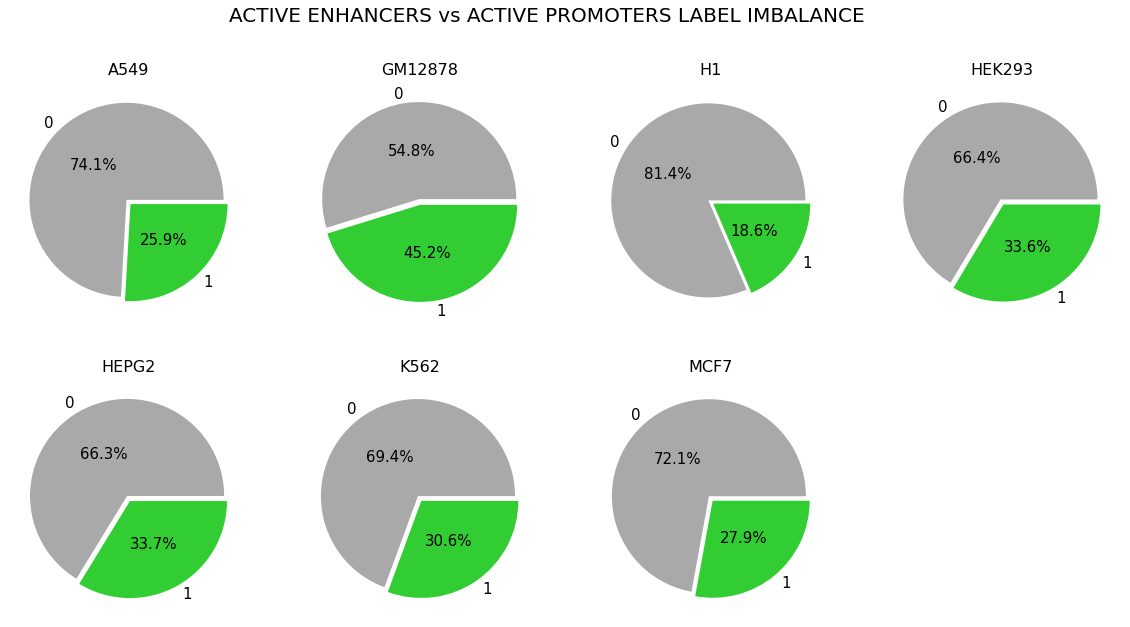

In [5]:
plot_label_ratio(TASKS[2], 'ACTIVE ENHANCERS vs ACTIVE PROMOTERS LABEL IMBALANCE')

Data Preprocessing Done!


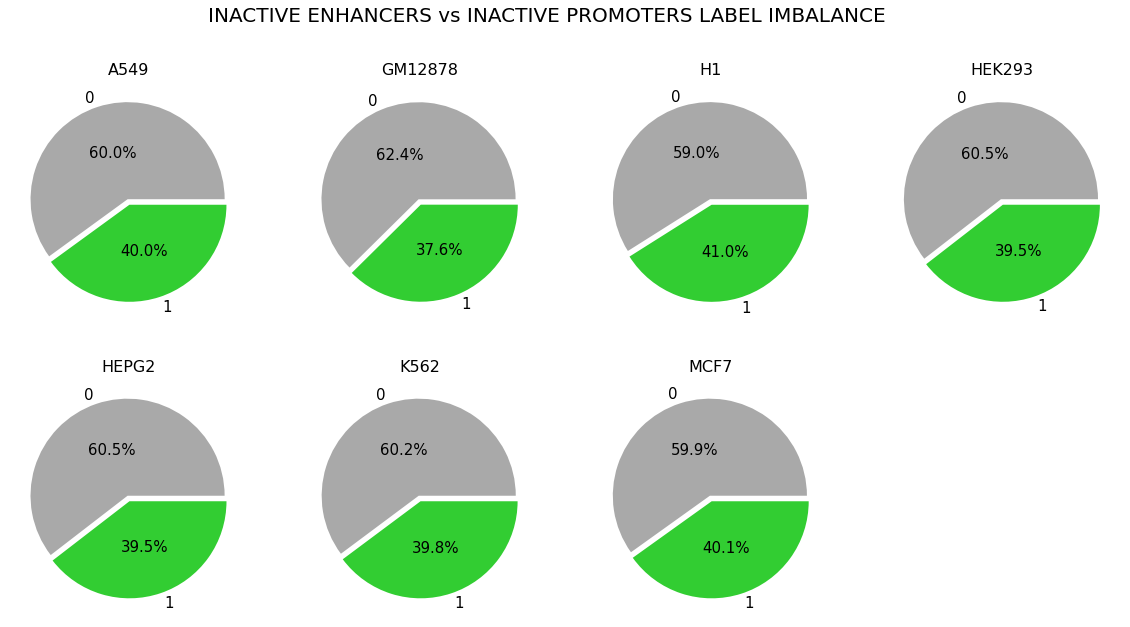

In [6]:
plot_label_ratio(TASKS[3], 'INACTIVE ENHANCERS vs INACTIVE PROMOTERS LABEL IMBALANCE')

Data Preprocessing Done!


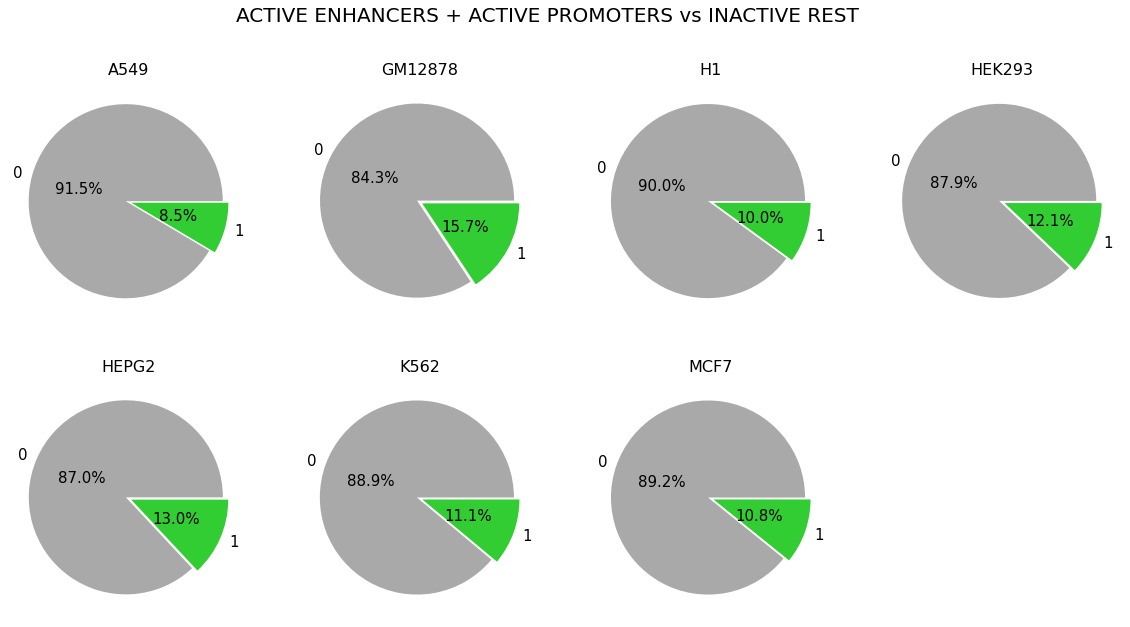

In [7]:
plot_label_ratio(TASKS[4], 'ACTIVE ENHANCERS + ACTIVE PROMOTERS vs INACTIVE REST')

In [8]:
from BIOINF_tesi.data_pipe.dataload import TASKS
from BIOINF_tesi.data_pipe.dataprepare import CELL_LINES

from BIOINF_tesi.visual import get_imbalance_ratio_df

In [9]:
imb_ratio = get_imbalance_ratio_df()

Data Preprocessing Done!
Data Preprocessing Done!
Data Preprocessing Done!
Data Preprocessing Done!
Data Preprocessing Done!


In [37]:
imb_ratio

,active_E_vs_inactive_E,active_P_vs_inactive_P,active_E_vs_active_P,inactive_E_vs_inactive_P,active_EP_vs_inactive_rest
A549,16.565,8.695,2.859,1.501,10.734
GM12878,4.461,6.116,1.211,1.661,5.367
H1,19.831,6.494,4.387,1.437,8.969
HEK293,8.525,6.602,1.977,1.531,7.248
HEPG2,7.818,6.088,1.963,1.529,6.672
K562,10.456,6.975,2.267,1.512,8.041
MCF7,11.886,6.859,2.588,1.493,8.26


---

### BASELINE FOR AUPRC

In [1]:
from BIOINF_tesi.visual import get_baseline_df

In [2]:
baseline = get_baseline_df()
baseline

Data Preprocessing Done!
Data Preprocessing Done!
Data Preprocessing Done!
Data Preprocessing Done!
Data Preprocessing Done!


,active_E_vs_inactive_E,active_P_vs_inactive_P,active_E_vs_active_P,inactive_E_vs_inactive_P,active_EP_vs_inactive_rest
A549,0.1,0.103,0.259,0.4,0.1
GM12878,0.183,0.141,0.452,0.376,0.157
H1,0.1,0.133,0.186,0.41,0.1
HEK293,0.105,0.132,0.336,0.395,0.121
HEPG2,0.113,0.141,0.337,0.395,0.13
K562,0.1,0.125,0.306,0.398,0.111
MCF7,0.1,0.127,0.279,0.401,0.108


Save baseline for AUPRC in results_dict for later plotting 

In [7]:
import pickle
from collections import defaultdict
with open ('results_dict.pickle', 'rb') as fin:
    results_dict = pickle.load(fin)
    results_dict = defaultdict(lambda: defaultdict(dict), results_dict)

In [8]:
for cell in results_dict.keys():
    for task in results_dict[cell].keys():
        results_dict[cell][task]['baseline_AUPRC']=baseline.loc[cell][task]

In [9]:
from collections import OrderedDict
with open ('results_dict.pickle', 'wb') as fout:
    pickle.dump(OrderedDict(results_dict), fout)

---